cuda


Epoch [100/100]: 100%|██████████| 401/401 [00:16<00:00, 24.03it/s, acc=0.25, loss=2.07]  


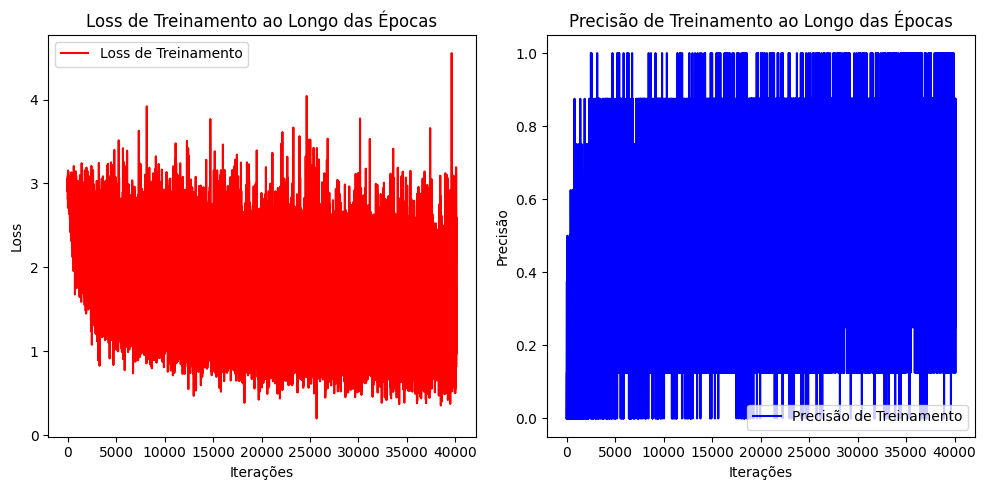

Accuracy of the network on the 104 test images: 82 %
                            precision    recall  f1-score   support

           ABBOTTS BABBLER       0.75      0.60      0.67         5
             ABBOTTS BOOBY       1.00      0.40      0.57         5
ABYSSINIAN GROUND HORNBILL       0.67      0.80      0.73         5
     AFRICAN CROWNED CRANE       0.57      0.80      0.67         5
    AFRICAN EMERALD CUCKOO       1.00      0.80      0.89         5
         AFRICAN FIREFINCH       1.00      1.00      1.00         5
    AFRICAN OYSTER CATCHER       1.00      0.60      0.75         5
     AFRICAN PIED HORNBILL       1.00      1.00      1.00         5
       AFRICAN PYGMY GOOSE       0.71      1.00      0.83         5
                 ALBATROSS       0.67      0.80      0.73         5
            ALBERTS TOWHEE       1.00      1.00      1.00         5
      ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
             ALPINE CHOUGH       1.00      0.80      0.89     

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


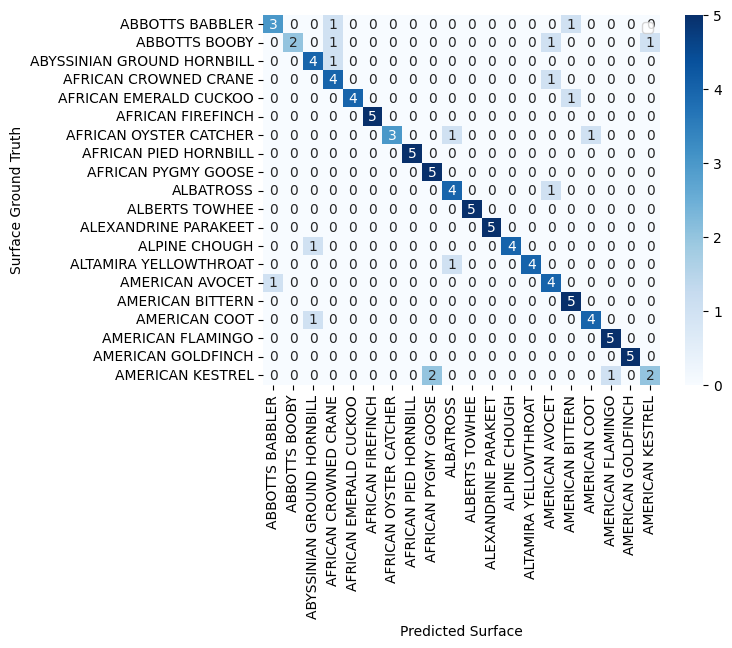

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Data
ROOT_PATH = 'imagens/'
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(os.path.join(ROOT_PATH, x), data_transforms[x]) 
    for x in ['train', 'test']
}

batch_size = 8
num_workers = 4

data_loaders = {
    x: DataLoader(image_datasets[x], shuffle=True, batch_size=batch_size, num_workers=4)
    for x in ['train', 'test']
}

class_names = image_datasets['train'].classes

# Lista para armazenar os valores de loss e precisão
train_losses = []
train_accuracies = []

# Model
num_classes = len(class_names)
cnn_model = SimpleCNN(num_classes=num_classes)
cnn_model = cnn_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.000001)

# Train
num_epoch = 100
for epoch in range(num_epoch):
    train_acc = 0
    train_loss = 0
    loop = tqdm(data_loaders['train'])
    for idx, (features, labels) in enumerate(loop):
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(features)
        loss = criterion(outputs, labels)

        predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
        correct = (predictions == labels).sum().item()
        accuracy = correct / batch_size

        loss.backward()
        optimizer.step()

        # Adicionar valores de loss e precisão às listas
        train_losses.append(loss.item())
        train_accuracies.append(accuracy)

        loop.set_description(f"Epoch [{epoch+1}/{num_epoch}]")
        loop.set_postfix(loss=loss.item(), acc=accuracy)

# Plotar os valores de loss e precisão ao longo do treinamento
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'r', label='Loss de Treinamento')
plt.title('Loss de Treinamento ao Longo das Épocas')
plt.xlabel('Iterações')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, 'b', label='Precisão de Treinamento')
plt.title('Precisão de Treinamento ao Longo das Épocas')
plt.xlabel('Iterações')
plt.ylabel('Precisão')
plt.legend()

plt.tight_layout()
plt.show()

# Test
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
test_predicted = []
test_labels = []

with torch.no_grad():
    for features, labels in data_loaders["test"]:
        features = features.to('cuda')
        labels = labels.to('cuda')

        # calculate outputs by running images through the network
        outputs = cnn_model(features)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cuda') == labels).sum().item()
        
        test_labels += (labels.cpu().numpy().tolist())
        test_predicted += (predicted.cpu().numpy().tolist())

print(f'Accuracy of the network on the {len(data_loaders["test"])*batch_size} test images: {100 * correct // total} %')

# Report
print(classification_report(test_labels, test_predicted, target_names=class_names))

cm = confusion_matrix(test_labels, test_predicted)
df_cm = pd.DataFrame(
    cm, 
    index=class_names,
    columns=class_names
)

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    plt.ylabel("Surface Ground Truth")
    plt.xlabel("Predicted Surface")
    plt.legend()

show_confusion_matrix(df_cm)
